# Leaf Area Index Retrieval

Author: [Lukas Valentin Graf](https://github.com/lukasValentin/lukasValentin) (2023)

## Learning Objectives

In this notebook you will learn how to

* retrieve the green leaf area index from Sentinel-2 imagery using PROSAIL
* get some background information about the green leaf area index.

## Tutorial Pre-Requisites

This tutorial is advanced level. If you are unfamiliar with `EOdal`, better start [with the basic introduction](/notebooks/General/Loading_Images.ipynb) and then continue [here](/notebooks/General/EOdal_Mapper.ipynb).


## Background
The leaf area index (LAI) - defined as ratio of one-sided leaf area to unit ground area - is an important functional trait that is a proxy for the net assimilation rate in crops [Watson, 1958](https://www.jstor.org/stable/42907407). LAI can be split in two components: Green LAI (GLAI) and brown LAI (BLAI). GLAI and BLAI form the total LAI. GLAI is the LAI of the photosynthetically-active leaf area, while BLAI refers to non-photosynthetically leaf area, i.e., senescent or necrotic leaves.

LAI correlates linearly with the fraction of incident solar radition intercepted by a canopy [Monsi and Saeki, 1953](https://doi.org/10.1093/aob/mci052) and can therefore be estimated from remotely sensed imagery using [canopy radiative transfer models (RTM)](https://edepot.wur.nl/210943).

In this notebook, we will present a methodology using the four-stream RTM [PROSAIL](http://teledetection.ipgp.jussieu.fr/prosail/) to retrieve the GLAI for a winter wheat canopy during the stem elongation (BBCH 30) to heading phase (BBCH 59) from Sentinel-2 imagery. The methodology follows the work by [Graf et al. (2023)](https://doi.org/10.1016/j.rse.2023.113860).

## Install required software

First, we need to install [glai_processor software](https://github.com/terensis/GLAIProcessor_Optical_GPL3) that handles the actual GLAI retrieval from Sentinel-2.

In [1]:
!pip install git+https://github.com/terensis/GLAIProcessor_Optical_GPL3

DEPRECATION: Loading egg at /mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/crop_phenology-0.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  Cloning https://github.com/terensis/GLAIProcessor_Optical_GPL3 to /tmp/pip-req-build-esgeu3s_
  Running command git clone --filter=blob:none --quiet https://github.com/terensis/GLAIProcessor_Optical_GPL3 /tmp/pip-req-build-esgeu3s_
  Resolved https://github.com/terensis/GLAIProcessor_Optical_GPL3 to commit 34d4b0ef3d331422091332ff1c2a0c982676783c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/EOA-team/eodal to /tmp/pip-install-982qcv5b/eodal_5d944b2a5f044b7ba59ef77ef5b67593
  Running command git clone --filter=blob:none --quiet https://github.com/EOA-team/eodal /tmp/pip-install-982qcv5b/eodal_5d944b2a5f044b7ba59ef77ef5b67593
  Res

## How it works

Three steps are required to get to the GLAI

1. We have to fetch the Sentinel-2 surface reflectance data. We will use the 10 m bands B02 (blue), B03 (green), B04 (red), and B08 (near-infraread 1). Furthermore, we need to retrieve the angular information about illumination and viewing geometries as this required input by PROSAIL. Fortunately, this is already built-in into the `glai_processor`

2. Once we have the image data, we run the RTM in so-called "forward mode" to simulate synthetic Sentinel-2 spectra using a range of leaf and canopy traits (among which we also have the GLAI). A full list of all traits required and the statistical distributions used, can be found in [Graf et al. (2023)](https://doi.org/10.1016/j.rse.2023.113860). The simulated spectra are stored in lookup-tables (essentially `pandas.DataFrame` objects). There is one lookup-table for each Sentinel-2 scene as the angles are slightly different for each scene.

3. We use the real Sentinel-2 images and the simulated spectra to do the actual inversion. For the inversion, there is no analytical solution. Therefore, we have to compare "real" and simulated Sentinel-2 spectra stored in the lookup-tables per scene by means of a cost function (in our case simply the root-mean-squared error) to obtain estimates of the GLAI per pixel.

The result is a GLAI map for each Sentinel-2 scene in 10 m spatial resolution.

We define two functions first: The first function for fetching the Sentinel-2 data using `eodal`, and the second function for doing the actual inversion.


In [34]:
# necessary imports
import eodal
import geopandas as gpd
import numpy as np
import pandas as pd
import os

from datetime import datetime
from eodal.config import get_settings
from eodal.core.raster import RasterCollection, SceneProperties
from eodal.core.scene import SceneCollection
from eodal.core.sensors import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import MapperConfigs
from glai_processor.fetch_satellite_data import (
    fetch_data,
    preprocess_sentinel2_scene)
from glai_processor.inversion import invert
from glai_processor.utils import (
    load_angles,
    FPATH_SRF,
    PLATFORMS,
    SAMPLING_METHOD)
from pathlib import Path
from rtm_inv.core.lookup_table import generate_lut

settings = get_settings()
settings.USE_STAC = True

print('EOdal version: ', eodal.__version__)

EOdal version:  0.2.3


### Step 1: Fetch Sentinel-2 data

We focus on a single winter wheat parcel (2022 growing seaon) in Western Switzerland. The parcel is the same as used [here](sentinel2_crop_growing_conditions.ipynb). We will retrieve data for May 2022, only, to keep the processing requirements low. However, the methodology can be extended to the whole growing season and other geographic regions.

In [3]:
def extract_s2_data(
    start_date: datetime,
    end_date: datetime,
    fpath_feature: Path,
    output_dir: Path,
    band_selection: list[str] = ['blue', 'green', 'red', 'nir_1']
) -> None:
    """
    Fetch the Sentinel-2 data (VIS + NIR) in 10 m resolution
    and filter out all SCL classes but 4 and 5.

    Parameters
    ----------
    start_date : datetime
        Defines the start date.
    harvest_date : datetime
        Defines the end date.
    fpath_feature : Path
        Path to the feature file, i.e., the field parcel, area
        of interest for which to fetch the data.
    output_dir : Path
        Path to the output directory.
    band_selection : list[str], optional
        List of Sentinel-2 bands to be fetched, by default
        ['blue', 'green', 'red', 'nir_1']
    """
    feature = Feature.from_geoseries(
        gpd.read_file(fpath_feature).dissolve().geometry
    )
    metadata_filters: list[Filter] = [
        Filter('cloudy_pixel_percentage', '<', 50),
        Filter('processing_level', '==', 'Level-2A')
    ]

    # define the scene kwargs
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,
        'scene_constructor_kwargs': {'band_selection': band_selection.copy(),
                                     'apply_scaling': False,
                                     'read_scl': True},
        'scene_modifier': preprocess_sentinel2_scene,
        'scene_modifier_kwargs': {'target_resolution': 10}
    }
    # define the mapper configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=start_date,
        time_end=end_date,
        feature=feature,
        metadata_filters=metadata_filters)

    # fetch the data
    fetch_data(
        mapper_configs=mapper_configs,
        scene_kwargs=scene_kwargs,
        band_selection=band_selection,
        output_dir=output_dir
    )

In [13]:
# set the paths to the data
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent

# path to the field parcel for which to fetch the data
fpath_feature = base_dir.joinpath('data/sample_polygons/Parzelle35.shp')

# path to the output directory. All fetched data will be stored here
output_dir = base_dir.joinpath('results')
output_dir.mkdir(exist_ok=True)

# start and end date for the data fetch
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 5, 30)

extract_s2_data(
    start_date=start_date,
    end_date=end_date,
    fpath_feature=fpath_feature,
    output_dir=output_dir)

2023-11-03 15:11:51,805 eodal        INFO     Starting extraction of sentinel2 scenes
2023-11-03 15:11:54,794 eodal        INFO     Finished extraction of sentinel2 scenes
/mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/eodal/core/raster.py:1777: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(
/mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/eodal/core/raster.py:1777: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(
/mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/eodal/core/raster.py:1777: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(


### Step 2 and 3 - Generate the lookup tables and perform the inversion

This step can take a while as the RTM has to be run multiple times in forward mode (20000 times in the case per scene) to generate the synthetic spectra. The actual inversion is also performed. The result is a "*_traits.tiff" file in the [result folder](/results/) that has been generated in step 1 and filled with GeoTiff files containing the Sentinel-2 data.

In [27]:
def retrieve_traits(
    rtm_params: Path,
    output_dir: Path,
    traits: list[str] = ['lai', 'cab'],
    band_selection_lut: list[str] = ['B02', 'B03', 'B04', 'B08'],
    band_selection_srf: list[str] = ['blue', 'green', 'red', 'nir_1'],
    n_solutions: int = 2000,
    lut_size: int = 20000
) -> None:
    """
    Retrieve the traits from the Sentinel-2 data using the
    lookup-table based inversion of the PROSAIL RTM.

    Parameters
    ----------
    rtm_params : Path
        Path to the RTM parameters
    output_dir : Path
        Path to the output directory
    traits : list[str], optional
        List of traits to be retrieved, by default ['lai', 'cab']
    band_selection_lut : list[str], optional
        List of Sentinel-2 bands to be used for the lookup-tables,
        by default ['B02', 'B03', 'B04', 'B08']
    band_selection_srf : list[str], optional
        List of Sentinel-2 bands to be used for the spectral response
        functions, by default ['blue', 'red', 'green', 'nir_1']
    n_solutions : int, optional
        Number of solutions to be retrieved, by default 2000.
    lut_size : int, optional
        Size of the lookup-tables, by default 20000
    """
    # iterate over all angle files
    for yaml_file in output_dir.glob('S2*_angles.yaml'):
        # load the angles
        angles = load_angles(yaml_file)

        fname_lut = yaml_file.name.replace(
            'angles.yaml', 'lut.pkl'
        )

        # GeoTiff file containing the spectral values
        band_names_file = '-'.join(band_selection_srf) + '.tiff'
        fname_srf = yaml_file.name.replace(
            'angles.yaml', band_names_file)
        fpath_srf = output_dir.joinpath(fname_srf)
        # get the platform from the file name
        platform = PLATFORMS[fpath_srf.name.split('_')[0]]

        # generate the lookup-tables using the methodology from
        # Graf et al. (2023, RSE, https://doi.org/10.1016/j.rse.2023.113860)
        if not output_dir.joinpath(fname_lut).exists():
            lut_srf = generate_lut(
                sensor=platform,
                lut_params=rtm_params,
                solar_zenith_angle=angles['solar_zenith_angle'],
                viewing_zenith_angle=angles['viewing_zenith_angle'],
                solar_azimuth_angle=angles['solar_azimuth_angle'],
                viewing_azimuth_angle=angles['viewing_azimuth_angle'],
                lut_size=lut_size,
                sampling_method=SAMPLING_METHOD,
                fpath_srf=FPATH_SRF,
                remove_invalid_green_peaks=True,
                linearize_lai=False
            )
        else:
            lut_srf = pd.read_pickle(output_dir.joinpath(fname_lut))

        # save the lookup-tables
        lut_srf.dropna(inplace=True)
        fpath_lut = output_dir.joinpath(fname_lut)
        lut_srf.to_pickle(fpath_lut)

        # invert the RTM
        invert(
            fpath_lut=fpath_lut,
            fpath_srf=fpath_srf,
            output_dir=output_dir,
            band_selection_lut=band_selection_lut,
            band_selection_srf=band_selection_srf,
            traits=traits,
            n_solutions=n_solutions
        )


For the generation of the lookup-table and the subsequent inversion, we stick to defaults. However, this might not be the optimum settings and are mainly used for pure demonstration purposes.

In the below you see the leaf and canopy parameters and how they are varied using Gaussian or Uniform distributions.

In [18]:
# we need to the RTM which leaf and canopy parameter combinations to use.
# Here, we use the settings suggested by Danner et al. 
rtm_params = pd.read_csv('https://raw.githubusercontent.com/EOA-team/sentinel2_crop_traits/main/src/lut_params/prosail_danner-etal_all_phases.csv')
rtm_params

,Parameter,Min,Max,Mode,Std,Distribution
0,n,1.00,2.50,1.50,0.20,Gaussian
1,cab,0.00,80.00,50.00,40.00,Gaussian
2,car,0.00,15.00,NaN,NaN,Gaussian
3,ant,0.00,5.00,2.00,0.80,Gaussian
4,cbrown,0.00,1.00,NaN,NaN,Uniform
5,cw,0.00,0.07,0.04,0.02,Gaussian
6,cm,0.00,0.01,NaN,NaN,Uniform
7,lai,0.00,8.00,NaN,NaN,Uniform
8,lidfa,30.00,70.00,45.00,15.00,Uniform
9,lidfb,0.00,0.00,NaN,NaN,Constant


In [28]:
retrieve_traits(
    rtm_params=rtm_params,
    output_dir=output_dir
)

/mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/eodal/core/raster.py:1777: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(
/mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Simulated spectrum 500/20000
Simulated spectrum 1000/20000
Simulated spectrum 1500/20000
Simulated spectrum 2000/20000
Simulated spectrum 2500/20000
Simulated spectrum 3000/20000
Simulated spectrum 3500/20000
Simulated spectrum 4000/20000
Simulated spectrum 4500/20000
Simulated spectrum 5000/20000
Simulated spectrum 5500/20000
Simulated spectrum 6000/20000
Simulated spectrum 6500/20000
Simulated spectrum 7000/20000
Simulated spectrum 7500/20000
Simulated spectrum 8000/20000
Simulated spectrum 8500/20000
Simulated spectrum 9000/20000
Simulated spectrum 9500/20000
Simulated spectrum 10000/20000
Simulated spectrum 10500/20000
Simulated spectrum 11000/20000
Simulated spectrum 11500/20000
Simulated spectrum 12000/20000
Simulated spectrum 12500/20000
Simulated spectrum 13000/20000
Simulated spectrum 13500/20000
Simulated spectrum 14000/20000
Simulated spectrum 14500/20000
Simulated spectrum 15000/20000
Simulated spectrum 15500/20000
Simulated spectrum 16000/20000
Simulated spectrum 16500/200

/mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/eodal/core/raster.py:1777: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(
/mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Simulated spectrum 500/20000
Simulated spectrum 1000/20000
Simulated spectrum 1500/20000
Simulated spectrum 2000/20000
Simulated spectrum 2500/20000
Simulated spectrum 3000/20000
Simulated spectrum 3500/20000
Simulated spectrum 4000/20000
Simulated spectrum 4500/20000
Simulated spectrum 5000/20000
Simulated spectrum 5500/20000
Simulated spectrum 6000/20000
Simulated spectrum 6500/20000
Simulated spectrum 7000/20000
Simulated spectrum 7500/20000
Simulated spectrum 8000/20000
Simulated spectrum 8500/20000
Simulated spectrum 9000/20000
Simulated spectrum 9500/20000
Simulated spectrum 10000/20000
Simulated spectrum 10500/20000
Simulated spectrum 11000/20000
Simulated spectrum 11500/20000
Simulated spectrum 12000/20000
Simulated spectrum 12500/20000
Simulated spectrum 13000/20000
Simulated spectrum 13500/20000
Simulated spectrum 14000/20000
Simulated spectrum 14500/20000
Simulated spectrum 15000/20000
Simulated spectrum 15500/20000
Simulated spectrum 16000/20000
Simulated spectrum 16500/200

/mnt/ides/Lukas/venvs/GeoPython/lib/python3.11/site-packages/eodal/core/raster.py:1777: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(


## Visualize the results

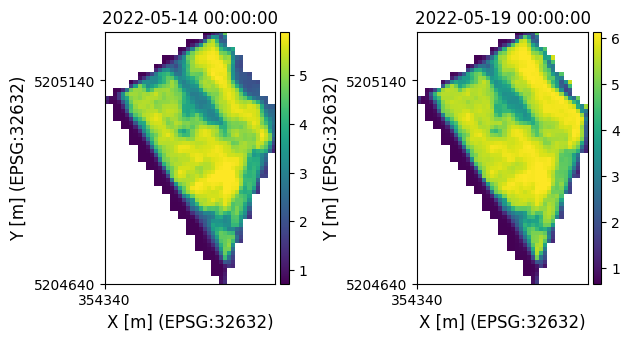

In [33]:
scoll = SceneCollection()
trait_selected = 'lai'
for fpath_trait in output_dir.glob('*_traits.tiff'):
    sensing_date = datetime.strptime(
        fpath_trait.name.split('_')[1], '%Y-%m-%d')
    trait_ds = RasterCollection.from_multi_band_raster(
        fpath_trait, band_names_src=[trait_selected])
    # check if the trait is masked
    if trait_ds[trait_selected].is_masked_array:
        if trait_ds[trait_selected].values.mask.all():
            continue
    else:
        if np.isnan(trait_ds[trait_selected].values).all():
            continue
    scene_properties = SceneProperties(
        acquisition_time=sensing_date)
    trait_ds.scene_properties = scene_properties
    scoll.add_scene(trait_ds)

# sort scenes by acquisition time
scoll = scoll.sort()

f = scoll.plot(max_scenes_in_row=len(scoll), band_selection=['lai'])

The GLAI was generated for two scenes, only, as on the 9th of May all pixel values have been masked out due to clouds. The GLAI ranges between typical values for winter wheat at this time of the year in Switzerland, when the plants are close to the heading date. Around heading, we expect to see the highest GLAI values in winter wheat.

The analysis could be extended using the same methodology to the entire growing period of winter wheat (in this case, between October 2021 and end of July 2022). The most time consuming factor is the generation of the lookup-tables.